In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Do_portfolio import Do_portfolio
from yahoo_data import yahoo_data
import metrics_portfolio
from FinancialForecastModels import FinancialForecastModels


# --- Parámetros generales (mismos que para el P1) ---

start_date = "2020-08-01"   # ventana histórica "larga"
end_date   = "2025-07-31"   # puedes ajustar si quieres algo más reciente

periods_per_year = 252      # datos diarios
rf_ann_assumed = 0.0        # Sharpe vs rf=0 en este bloque (luego podemos meter ^IRX)


# Definir el Segundo Portafolio (tickers + pesos)

In [2]:
# ---------- SEGUNDO PORTAFOLIO (P2) ----------

tickers_p2 = [
    "GLD",
    "SHY",
    "TIP",
    "NVDA",
    "KO",
    "BTC-USD",
    "JPM",
    "AAPL",
    "IEF",
    "TSLA",
]

# Pesos en porcentaje que tú definiste
weights_p2_raw = np.array([
    25.00,   # GLD
    25.00,   # SHY
    20.29,   # TIP
    12.80,   # NVDA
    8.33,    # KO
    2.75,    # BTC-USD
    2.11,    # JPM
    1.99,    # AAPL
    1.13,    # IEF
    0.61,    # TSLA
])

# Pasar a proporción y normalizar (por si la suma por redondeo no es exactamente 1)
weights_p2 = weights_p2_raw / 100.0
weights_p2 = weights_p2 / weights_p2.sum()

print("Vector de pesos del Segundo Portafolio (P2) en proporción, normalizado a suma 1:\n")
for t, w in zip(tickers_p2, weights_p2):
    print(f"  {t:7s}: {w:.4f}")


Vector de pesos del Segundo Portafolio (P2) en proporción, normalizado a suma 1:

  GLD    : 0.2500
  SHY    : 0.2500
  TIP    : 0.2029
  NVDA   : 0.1280
  KO     : 0.0833
  BTC-USD: 0.0275
  JPM    : 0.0211
  AAPL   : 0.0199
  IEF    : 0.0113
  TSLA   : 0.0061


## Construir objeto Do_portfolio y ver precios

In [3]:
# ---------- Instanciar Do_portfolio con los activos del P2 ----------

dp_p2 = Do_portfolio(
    tickers=tickers_p2,
    start=start_date,
    end=end_date,
)

prices_p2 = dp_p2.info.data.copy()

print("\nTabla 0 – Primeras filas de precios diarios (5 años) para los activos del Portafolio 2:")
print("Cada columna es un activo; las filas son fechas. Valores son precios (por defecto Adj Close).\n")
print(prices_p2.head())



Tabla 0 – Primeras filas de precios diarios (5 años) para los activos del Portafolio 2:
Cada columna es un activo; las filas son fechas. Valores son precios (por defecto Adj Close).

Ticker            AAPL       BTC-USD         GLD         IEF        JPM  \
Date                                                                      
2020-08-01         NaN  11759.592773         NaN         NaN        NaN   
2020-08-02         NaN  11053.614258         NaN         NaN        NaN   
2020-08-03  105.672295  11246.348633  185.639999  108.051712  83.626129   
2020-08-04  106.377975  11205.892578  189.589996  108.421761  83.147522   
2020-08-05  106.763573  11747.022461  191.350006  108.060524  84.592049   

Ticker             KO       NVDA        SHY         TIP       TSLA  
Date                                                                
2020-08-01        NaN        NaN        NaN         NaN        NaN  
2020-08-02        NaN        NaN        NaN         NaN        NaN  
2020-08-03  39

### Tabla 0 – Precios diarios del Portafolio 2 y presencia de `NaN`

En esta tabla vemos los precios diarios de los activos del **Portafolio 2** (AAPL, BTC-USD, GLD, IEF, JPM, KO, NVDA, SHY, TIP, TSLA) en los últimos 5 años.

Los valores `NaN` de las primeras filas **no son un error**, sino algo normal en datos financieros:

- Acciones y ETFs de EE. UU. (AAPL, GLD, IEF, JPM, KO, NVDA, SHY, TIP, TSLA) **no cotizan fines de semana ni festivos**, por eso en fechas como 2020-08-01 y 2020-08-02 no hay precio y aparecen `NaN`.
- Bitcoin (**BTC-USD**) sí cotiza 24/7, así que en esos días solo hay precio para BTC-USD y el resto de columnas quedan en `NaN`.
- La clase `yahoo_data` elimina únicamente las filas donde **todas** las columnas son `NaN`, por eso se conservan estas fechas en las que al menos BTC-USD tiene dato.
- Posteriormente, cuando calculamos retornos con `compute_returns(...).dropna()`, esas filas con huecos se eliminan y **no afectan** los cálculos del modelo de Markowitz ni del resto de metodologías.


## Estimar μ (rendimientos esperados) y Σ (covarianza) históricos

In [4]:
# ---------- Estimación histórica de retorno y riesgo por activo (P2) ----------

# Retornos esperados anuales (media histórica de retornos simples diarios * 252)
mu_hist_p2 = dp_p2.mean_estimation(tipo="hist", periods_per_year=periods_per_year)

# Matriz de covarianza anual (cov diaria * 252)
Sigma_hist_p2 = dp_p2.var_estimation(tipo="hist", periods_per_year=periods_per_year)

# Tabla resumen por activo: retorno anual y medida de riesgo anual
asset_stats_p2 = pd.DataFrame({
    "Retorno_anual":  mu_hist_p2,
    "Riesgo_anual":   np.sqrt(np.diag(Sigma_hist_p2)),
})

print("\nTabla 1 – Estadísticas anuales por activo del Portafolio 2 (estimación histórica):")
print(
    "Retorno_anual = cuánto ha ganado en promedio cada activo por año, usando los datos históricos.\n"
    "Riesgo_anual  = qué tanto se ha movido ese activo en el tiempo: valores más altos indican\n"
    "                precios más volátiles (subidas y bajadas más fuertes).\n"
)
print(asset_stats_p2.round(4))





Tabla 1 – Estadísticas anuales por activo del Portafolio 2 (estimación histórica):
Retorno_anual = cuánto ha ganado en promedio cada activo por año, usando los datos históricos.
Riesgo_anual  = qué tanto se ha movido ese activo en el tiempo: valores más altos indican
                precios más volátiles (subidas y bajadas más fuertes).

         Retorno_anual  Riesgo_anual
Ticker                              
AAPL            0.1236        0.2434
BTC-USD         0.4476        0.4955
GLD             0.0750        0.1279
IEF            -0.0178        0.0638
JPM             0.1983        0.2122
KO              0.0851        0.1372
NVDA            0.4819        0.4389
SHY             0.0082        0.0159
TIP             0.0077        0.0521
TSLA            0.3004        0.5277


/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()
/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


### Tabla 1 – Estadísticas anuales por activo del Portafolio 2

En esta tabla vemos, para cada activo que compone el Portafolio 2, dos medidas históricas:

- **Retorno_anual**  
  Cuánto ha ganado en promedio el activo por año, usando los datos de los últimos años.

- **Riesgo_anual**  
  Qué tan inestable ha sido el activo: valores altos indican que sus precios han tenido
  subidas y bajadas fuertes; valores bajos corresponden a activos más tranquilos.

Por ejemplo:
- BTC-USD y TSLA aparecen con retornos anuales altos, pero también con niveles de riesgo elevados.
- SHY y TIP tienen retornos pequeños y riesgo bajo, coherente con instrumentos de renta fija.
- IEF muestra un retorno_anual ligeramente negativo en este periodo, a pesar de tener un riesgo moderado.


# Frontera eficiente de Markowitz para los activos del P2

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()



Tabla 2 – Puntos de la frontera eficiente (primeras filas) para los activos del P2:
Cada fila es un portafolio eficiente:
  target_return   = retorno objetivo usado en la optimización
  expected_return = retorno anual del portafolio óptimo
  volatility      = volatilidad anual del portafolio óptimo
  variance        = varianza anual del portafolio óptimo.

   target_return  expected_return  volatility  variance
0         0.0107           0.0107      0.0156    0.0002
1         0.0203           0.0203      0.0174    0.0003
2         0.0299           0.0299      0.0214    0.0005
3         0.0395           0.0395      0.0265    0.0007
4         0.0491           0.0491      0.0321    0.0010

Tabla 4 – Comparación de P2 vs portafolios de referencia de Markowitz:
Filas:
  P2                 = portafolio con pesos fijos
  PMV                = portafolio de mínima varianza (riesgo mínimo)
  Tangente           = portafolio de máxima razón de Sharpe (vs rf=0)

Columnas:
  μ_ann  = retorno anual 

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


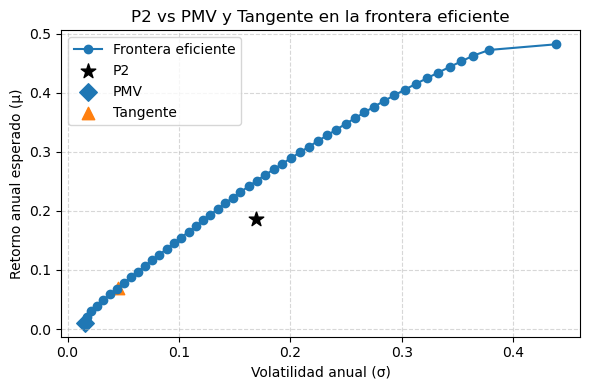

In [5]:
# ---------- Frontera eficiente (Markowitz) con los activos del P2 ----------

ef_p2 = Do_portfolio.efficient_frontier(
    dp_p2,                # <-- importante: pasamos la instancia como primer argumento
    n_points=50,          # número de puntos a lo largo de la frontera
    mu_targets=None,      # que escoja automáticamente un rango de retornos objetivo
    mu=None,
    Sigma=None,
    long_only=True,       # sin cortos en esta primera versión
    kind="simple",
    periods_per_year=periods_per_year,
    solver=None,
)

curve_p2 = ef_p2["curve"]  # DataFrame con target_return, expected_return, volatility, variance

print("\nTabla 2 – Puntos de la frontera eficiente (primeras filas) para los activos del P2:")
print("Cada fila es un portafolio eficiente:\n"
      "  target_return   = retorno objetivo usado en la optimización\n"
      "  expected_return = retorno anual del portafolio óptimo\n"
      "  volatility      = volatilidad anual del portafolio óptimo\n"
      "  variance        = varianza anual del portafolio óptimo.\n")
print(curve_p2.head().round(4))


# ---------- Métricas del Portafolio 2 (P2) ----------

# Retornos simples diarios de los activos del P2
rets_simple_p2 = dp_p2.info.compute_returns(kind="simple")

metrics_p2 = metrics_portfolio.annualize_stats(
    rets=rets_simple_p2,
    weights=weights_p2,           # pesos del P2 en proporción
    rf=rf_ann_assumed,            # misma rf que usaste en P1 (aquí 0)
    periods_per_year=periods_per_year,
    kind="simple",
)


# ---------- PMV y Tangente para comparar con P2 ----------

pmv_info_p2 = dp_p2.pmv_info(mu_hist_p2, Sigma_hist_p2, long_only=True)
tan_info_p2 = dp_p2.tangency_portfolio(
    mu_hist_p2,
    Sigma_hist_p2,
    rf_ann=rf_ann_assumed,
    long_only=True,
)

# Construir tabla comparativa (misma estructura que en P1)
comp_df_p2 = pd.DataFrame([
    {
        "Portafolio": "P2",
        "μ_ann": metrics_p2.ann_return,
        "σ_ann": metrics_p2.ann_vol,
        "Sharpe": metrics_p2.sharpe,
    },
    {
        "Portafolio": "PMV (mínima varianza)",
        "μ_ann": pmv_info_p2["expected_return"],
        "σ_ann": pmv_info_p2["volatility"],
        "Sharpe": (pmv_info_p2["expected_return"] - rf_ann_assumed) / pmv_info_p2["volatility"]
                  if pmv_info_p2["volatility"] > 0 else np.nan,
    },
    {
        "Portafolio": "Tangente (máx. Sharpe)",
        "μ_ann": tan_info_p2["expected_return"],
        "σ_ann": tan_info_p2["volatility"],
        "Sharpe": tan_info_p2["sharpe"],
    },
])

comp_df_p2 = comp_df_p2.set_index("Portafolio")

print("\nTabla 4 – Comparación de P2 vs portafolios de referencia de Markowitz:")
print("Filas:\n"
      "  P2                 = portafolio con pesos fijos\n"
      "  PMV                = portafolio de mínima varianza (riesgo mínimo)\n"
      "  Tangente           = portafolio de máxima razón de Sharpe (vs rf=0)\n\n"
      "Columnas:\n"
      "  μ_ann  = retorno anual esperado\n"
      "  σ_ann  = volatilidad anual\n"
      "  Sharpe = relación retorno/riesgo.\n")
print(comp_df_p2.round(4))


# ---------- Gráfica: P2 vs PMV y Tangente en la frontera eficiente ----------

plt.figure(figsize=(6, 4))
plt.plot(
    curve_p2["volatility"],
    curve_p2["expected_return"],
    "o-",
    label="Frontera eficiente",
)
plt.scatter(
    metrics_p2.ann_vol, metrics_p2.ann_return,
    marker="*", s=120, label="P2", color="black"
)
plt.scatter(
    pmv_info_p2["volatility"], pmv_info_p2["expected_return"],
    marker="D", s=80, label="PMV"
)
plt.scatter(
    tan_info_p2["volatility"], tan_info_p2["expected_return"],
    marker="^", s=80, label="Tangente"
)
plt.xlabel("Volatilidad anual (σ)")
plt.ylabel("Retorno anual esperado (μ)")
plt.title("P2 vs PMV y Tangente en la frontera eficiente")
plt.grid(ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# SARIMA / SARIMAX

## Serie de retornos del Portafolio 2

In [6]:
# 1) Retornos simples diarios de los activos del P2
rets_assets_simple_p2 = dp_p2.info.compute_returns(kind="simple")

print("\nTabla TS1 – Retornos simples diarios por activo (Portafolio 2):")
print(
    "Filas   = fechas de la muestra.\n"
    "Columnas = cada activo del Portafolio 2.\n"
    "Valor    = cambio porcentual diario del precio de cada activo (retorno simple diario).\n"
    "          Números positivos indican subidas, negativos caídas y valores cercanos a 0\n"
    "          movimientos muy pequeños. En días sin negociación de acciones (fines de semana),\n"
    "          algunos activos pueden mostrar retornos 0 porque su precio no cambia.\n"
)
print(rets_assets_simple_p2.head())


# 2) Retorno simple diario del portafolio P2 (combinación de los activos con sus pesos)
rets_port_p2 = rets_assets_simple_p2.dot(weights_p2)

print("\nTabla TS2 – Retornos simples diarios del Portafolio 2:")
print(
    "Columna única con el retorno simple diario del Portafolio 2.\n"
    "Cada valor es el resultado de combinar los retornos de todos los activos,\n"
    "ponderados por los pesos que definimos para P2.\n"
)
print(rets_port_p2.head())


# 3) Log-retornos diarios del portafolio: log(1 + r_t)
log_rets_port_p2 = np.log1p(rets_port_p2)
log_rets_port_p2.name = "log_ret_P2"

print("\nTabla TS3 – Log-retornos diarios del Portafolio 2:")
print(
    "Transformamos el retorno simple r_t en log(1 + r_t).\n"
    "Esta serie (log_ret_P2) es la que usaremos en los modelos AR, MA, ARMA y SARIMA,\n"
    "porque en finanzas suele comportarse mejor para este tipo de modelos.\n"
)
print(log_rets_port_p2.head())



Tabla TS1 – Retornos simples diarios por activo (Portafolio 2):
Filas   = fechas de la muestra.
Columnas = cada activo del Portafolio 2.
Valor    = cambio porcentual diario del precio de cada activo (retorno simple diario).
          Números positivos indican subidas, negativos caídas y valores cercanos a 0
          movimientos muy pequeños. En días sin negociación de acciones (fines de semana),
          algunos activos pueden mostrar retornos 0 porque su precio no cambia.

Ticker          AAPL   BTC-USD       GLD       IEF       JPM        KO  \
Date                                                                     
2020-08-04  0.006678 -0.003597  0.021278  0.003425 -0.005723  0.008423   
2020-08-05  0.003625  0.048290  0.009283 -0.003332  0.017373  0.011352   
2020-08-06  0.034889  0.002788  0.013274  0.001141  0.000308  0.005506   
2020-08-07 -0.022736 -0.015136 -0.015885 -0.002118  0.022008  0.006740   
2020-08-08  0.000000  0.013151  0.000000  0.000000  0.000000  0.000000   


/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


## Objeto de modelos de series de tiempo para el P2

In [7]:
# ---------- Objeto de modelos de series de tiempo para el Portafolio 2 ----------

ts_p2 = FinancialForecastModels(series=log_rets_port_p2, name="Portafolio 2 – log-retornos")
print("\nComentario:")
print("ts_p2 es el objeto que concentra todo el análisis de series de tiempo")
print("para los log-retornos diarios del Portafolio 2 (P2).")


Comentario:
ts_p2 es el objeto que concentra todo el análisis de series de tiempo
para los log-retornos diarios del Portafolio 2 (P2).


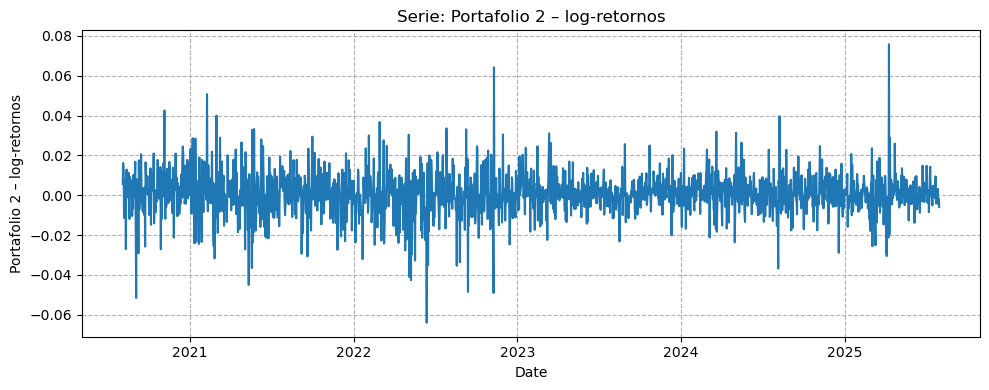


Comentario gráfico:
La figura muestra los log-retornos diarios del Portafolio 2 a lo largo del tiempo.
Visualmente buscamos que la serie oscile alrededor de cero, sin tendencia marcada
ni cambios fuertes en la escala. Ese comportamiento es lo que llamamos 'estacionario'.


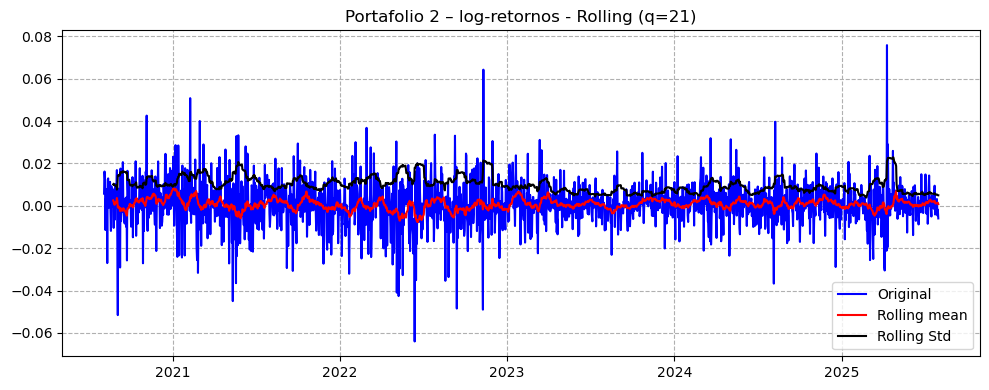


Comentario gráfico Rolling:
El gráfico de medias y desviaciones estándar móviles (ventana de 21 días)
resume cómo cambian el promedio y la variabilidad de los log-retornos en el tiempo.
Si ambas curvas se mantienen relativamente estables, es una señal adicional de
que la serie se comporta de forma aproximadamente estacionaria.
Resultados prueba Dickey-Fuller Aumentada:

        Values               Metrics
0   -44.698522       Test Statistics
1     0.000000               p-value
2     0.000000      No. of lags used
3  1821.000000          No. obs used
4    -3.433946   Critical Value (1%)
5    -2.863128   Critical Value (5%)
6    -2.567616  Critical Value (10%)

Comentario ADF:
La tabla recoge el estadístico de la prueba ADF y su p-valor.
Regla práctica: si el p-valor es menor que 0.05, rechazamos la hipótesis de
'no estacionariedad' y consideramos que la serie es estacionaria.
En retornos financieros es habitual obtener este tipo de resultado.


<Figure size 1000x400 with 0 Axes>

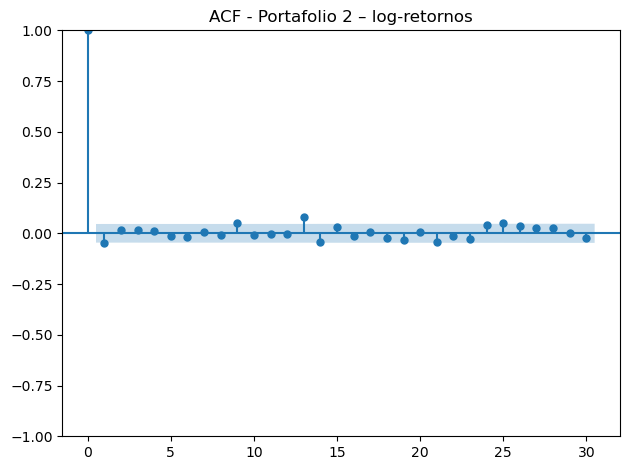

<Figure size 1000x400 with 0 Axes>

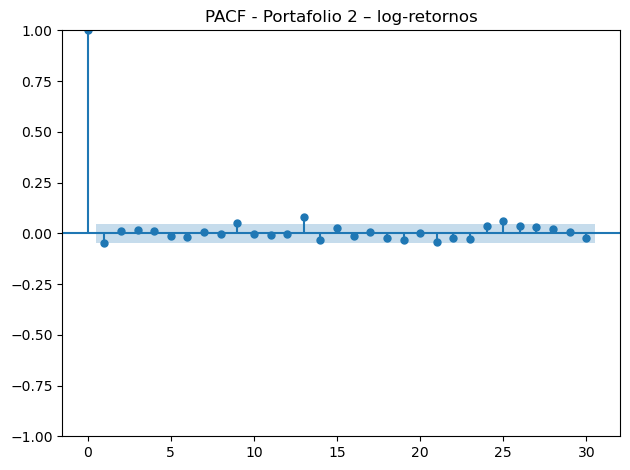


Comentario ACF/PACF:
Las gráficas ACF y PACF muestran cuánta memoria tiene la serie a distintos rezagos.
Que solo aparezcan pocos picos significativos sugiere usar modelos AR/MA/ARMA
de orden bajo (por ejemplo 1 ó 2), coherente con la práctica en series financieras.


In [8]:
# ---------- 3.1. Gráfico de la serie de log-retornos del P2 ----------
ts_p2.plot_series()

print("\nComentario gráfico:")
print("La figura muestra los log-retornos diarios del Portafolio 2 a lo largo del tiempo.")
print("Visualmente buscamos que la serie oscile alrededor de cero, sin tendencia marcada")
print("ni cambios fuertes en la escala. Ese comportamiento es lo que llamamos 'estacionario'.")

# ---------- 3.2. Rolling mean / std ----------
ts_p2.plot_rolling(q=21)  # ventana de ~1 mes de trading

print("\nComentario gráfico Rolling:")
print("El gráfico de medias y desviaciones estándar móviles (ventana de 21 días)")
print("resume cómo cambian el promedio y la variabilidad de los log-retornos en el tiempo.")
print("Si ambas curvas se mantienen relativamente estables, es una señal adicional de")
print("que la serie se comporta de forma aproximadamente estacionaria.")

# ---------- 3.3. Prueba de Dickey–Fuller Aumentada (ADF) ----------
adf_result_p2 = ts_p2.adf_test()

print("\nComentario ADF:")
print("La tabla recoge el estadístico de la prueba ADF y su p-valor.")
print("Regla práctica: si el p-valor es menor que 0.05, rechazamos la hipótesis de")
print("'no estacionariedad' y consideramos que la serie es estacionaria.")
print("En retornos financieros es habitual obtener este tipo de resultado.")

# ---------- 3.4. ACF y PACF ----------
ts_p2.plot_acf_pacf(lags=30)

print("\nComentario ACF/PACF:")
print("Las gráficas ACF y PACF muestran cuánta memoria tiene la serie a distintos rezagos.")
print("Que solo aparezcan pocos picos significativos sugiere usar modelos AR/MA/ARMA")
print("de orden bajo (por ejemplo 1 ó 2), coherente con la práctica en series financieras.")


## Ajuste AR(1), MA(1), ARMA(1,1)

In [9]:
# ---------- TS3.5 – Ajuste de modelos AR(1), MA(1) y ARMA(1,1) para el P2 ----------

# Modelo AR(1)
ar1_res_p2 = ts_p2.fit_arima(order=(1, 0, 0))

print("\nComentario AR(1) – P2:")
print("El resumen muestra los coeficientes del modelo AR(1) aplicado a los log-retornos del P2.")
print("Nos interesa que los residuos de este modelo se parezcan a ruido blanco,")
print("es decir, que no quede autocorrelación fuerte después del ajuste.")

# Modelo MA(1)
ma1_res_p2 = ts_p2.fit_arima(order=(0, 0, 1))

print("\nComentario MA(1) – P2:")
print("El resumen muestra los coeficientes del modelo MA(1) aplicado a los log-retornos del P2.")
print("Este modelo captura shocks transitorios en los retornos a corto plazo.")

# Modelo ARMA(1,1)
arma11_res_p2 = ts_p2.fit_arima(order=(1, 0, 1))

print("\nComentario ARMA(1,1) – P2:")
print("El resumen muestra los coeficientes del modelo ARMA(1,1) aplicado a los log-retornos del P2.")
print("Este modelo combina parte autorregresiva (AR) y de medias móviles (MA),")
print("y suele ser un punto de partida estándar en series financieras.")


                               SARIMAX Results                                
Dep. Variable:             log_ret_P2   No. Observations:                 1822
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5693.360
Date:                Sun, 23 Nov 2025   AIC                         -11380.719
Time:                        20:11:21   BIC                         -11364.196
Sample:                    08-04-2020   HQIC                        -11374.624
                         - 07-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.826      0.005       0.000       0.001
ar.L1         -0.0469      0.019     -2.525      0.012      -0.083      -0.011
sigma2         0.0001   2.08e-06     54.372      0.0

## Pronósticos AR(1), MA(1), ARMA(1,1)


Tabla TS4 – Pronósticos de log-retornos para el Portafolio 2 (P2):
Filas    = días futuros del horizonte de pronóstico (≈ 1 año hábil).
Columnas = modelo utilizado (AR(1), MA(1), ARMA(1,1)).
Valor    = log-retorno pronosticado del Portafolio 2 para cada día.

               AR(1)     MA(1)  ARMA(1,1)
2025-07-31  0.000995  0.001009   0.000991
2025-08-01  0.000669  0.000684   0.000624
2025-08-02  0.000684  0.000684   0.000696
2025-08-03  0.000683  0.000684   0.000682
2025-08-04  0.000683  0.000684   0.000685


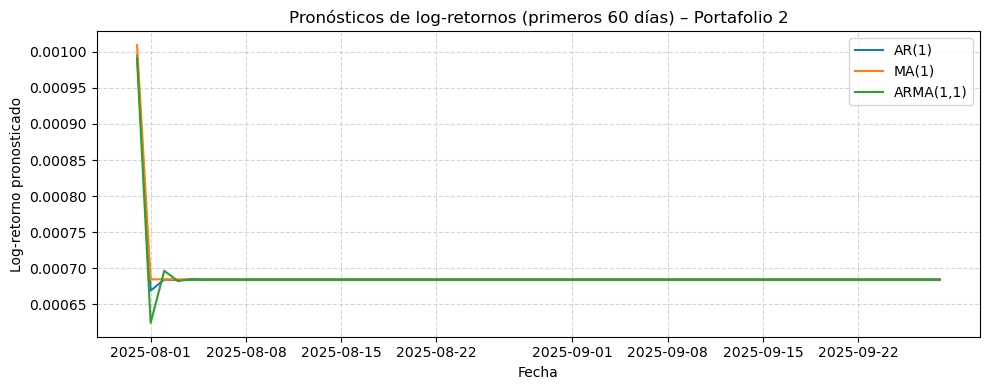


Comentario TS4 (pronósticos AR/MA/ARMA – P2):
La tabla resume los primeros días de los log-retornos pronosticados por cada modelo.
El gráfico permite visualizar cómo evolucionan estos pronósticos en el corto plazo.
En series financieras de retornos, los valores suelen ser pequeños y cercanos a cero,
por lo que estos modelos son más útiles para generar escenarios y simulaciones
que para adivinar el retorno exacto de un día en particular.


In [10]:
# ---------- TS4 – Pronósticos AR(1), MA(1) y ARMA(1,1) para el P2 ----------

# Horizonte de pronóstico: 252 días hábiles ≈ 1 año de trading
horizon_days = 252

# Pronósticos de log-retornos con cada modelo
fc_ar1_p2    = ar1_res_p2.forecast(steps=horizon_days)      # AR(1)
fc_ma1_p2    = ma1_res_p2.forecast(steps=horizon_days)      # MA(1)
fc_arma11_p2 = arma11_res_p2.forecast(steps=horizon_days)   # ARMA(1,1)

# Tabla con los primeros pronósticos
fc_df_p2 = pd.DataFrame({
    "AR(1)":      fc_ar1_p2,
    "MA(1)":      fc_ma1_p2,
    "ARMA(1,1)":  fc_arma11_p2,
})

print("\nTabla TS4 – Pronósticos de log-retornos para el Portafolio 2 (P2):")
print("Filas    = días futuros del horizonte de pronóstico (≈ 1 año hábil).")
print("Columnas = modelo utilizado (AR(1), MA(1), ARMA(1,1)).")
print("Valor    = log-retorno pronosticado del Portafolio 2 para cada día.\n")
print(fc_df_p2.head())

# ---------- Gráfico comparando los tres modelos en los primeros 60 días ----------
plt.figure(figsize=(10, 4))
plt.plot(fc_ar1_p2.iloc[:60].index,    fc_ar1_p2.iloc[:60].values,    label="AR(1)")
plt.plot(fc_ma1_p2.iloc[:60].index,    fc_ma1_p2.iloc[:60].values,    label="MA(1)")
plt.plot(fc_arma11_p2.iloc[:60].index, fc_arma11_p2.iloc[:60].values, label="ARMA(1,1)")
plt.title("Pronósticos de log-retornos (primeros 60 días) – Portafolio 2")
plt.xlabel("Fecha")
plt.ylabel("Log-retorno pronosticado")
plt.grid(ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("\nComentario TS4 (pronósticos AR/MA/ARMA – P2):")
print("La tabla resume los primeros días de los log-retornos pronosticados por cada modelo.")
print("El gráfico permite visualizar cómo evolucionan estos pronósticos en el corto plazo.")
print("En series financieras de retornos, los valores suelen ser pequeños y cercanos a cero,")
print("por lo que estos modelos son más útiles para generar escenarios y simulaciones")
print("que para adivinar el retorno exacto de un día en particular.")


## SARIMA/SARIMAX

                                     SARIMAX Results                                      
Dep. Variable:                         log_ret_P2   No. Observations:                 1822
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 21)   Log Likelihood                5690.567
Date:                            Sun, 23 Nov 2025   AIC                         -11371.134
Time:                                    20:11:22   BIC                         -11343.595
Sample:                                08-04-2020   HQIC                        -11360.974
                                     - 07-30-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2107      0.458     -0.460      0.645      -1.108       0.687
ma.L1          0.1670      0.459   

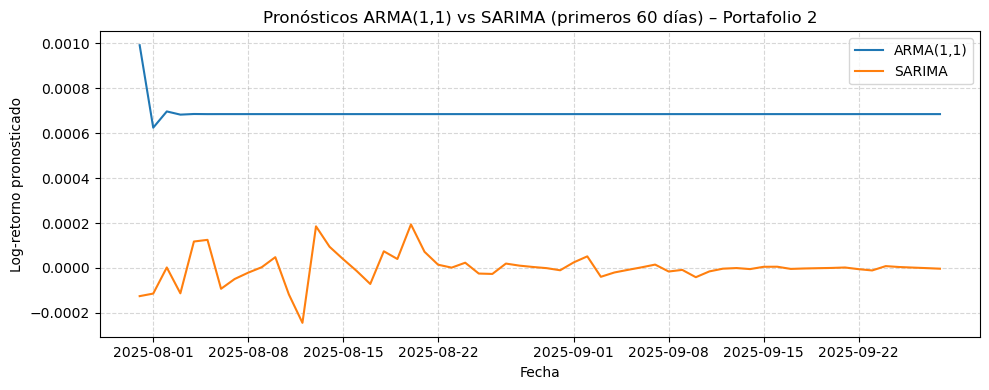


Comentario TS5 (SARIMA – P2):
El modelo SARIMA permite introducir un componente estacional sobre los log-retornos.
En muchas series financieras, esta estacionalidad es débil, por lo que los pronósticos
de SARIMA y ARMA(1,1) pueden verse muy parecidos. Aun así, este bloque deja documentado
cómo incorporar esta estructura cuando la estacionalidad sea relevante.


In [11]:
# ---------- TS5 – Modelo SARIMA (vía SARIMAX) para log-retornos del P2 ----------

sarima_res_p2 = ts_p2.fit_sarimax_model(
    order=(1, 0, 1),           # parte no estacional (ARMA(1,1))
    seasonal_order=(1, 0, 1, 21),  # estacionalidad aproximada de 21 días (≈ 1 mes hábil)
)

# Pronóstico SARIMA para el mismo horizonte
fc_sarima_p2 = ts_p2.forecast_sarimax(steps=horizon_days)

print("\nTabla TS5 – Primeras filas de pronóstico SARIMA para log-retornos del P2:")
print(
    "Columna única con el log-retorno pronosticado vía un modelo SARIMA\n"
    "que combina parte ARMA(1,1) con una estacionalidad mensual aproximada (21 días hábiles).\n"
)
print(fc_sarima_p2.head())

# Comparar ARMA(1,1) vs SARIMA en los primeros 60 días de pronóstico
plt.figure(figsize=(10, 4))
plt.plot(fc_arma11_p2.iloc[:60].index,  fc_arma11_p2.iloc[:60].values,  label="ARMA(1,1)")
plt.plot(fc_sarima_p2.iloc[:60].index, fc_sarima_p2.iloc[:60].values, label="SARIMA")
plt.title("Pronósticos ARMA(1,1) vs SARIMA (primeros 60 días) – Portafolio 2")
plt.xlabel("Fecha")
plt.ylabel("Log-retorno pronosticado")
plt.grid(ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("\nComentario TS5 (SARIMA – P2):")
print("El modelo SARIMA permite introducir un componente estacional sobre los log-retornos.")
print("En muchas series financieras, esta estacionalidad es débil, por lo que los pronósticos")
print("de SARIMA y ARMA(1,1) pueden verse muy parecidos. Aun así, este bloque deja documentado")
print("cómo incorporar esta estructura cuando la estacionalidad sea relevante.")


# Merton
## M1/M2 – μ y Σ históricos para el universo

In [31]:
# ==============================================================
# Serie con retornos CAPM diarios por activo (mismos valores que tu compa)
# ==============================================================

capm_rets_assets = pd.Series(
    {
        "SHY":     0.000127,
        "GLD":     0.000178,
        "TIP":     0.000152,
        "NVDA":    0.000847,
        "KO":      0.000213,
        "BTC-USD": 0.000467,
        "JPM":     0.000433,
        "TSLA":    0.000826,
        "AAPL":    0.000543,
        "IEF":     0.000142,
    },
    name="capm_ret_daily",
)

print("\nSerie CAPM – Retornos esperados diarios por activo (según el cálculo CAPM):")
print(
    "Índice = cada activo del universo (incluye todos los que aparecen en P1 y P2).\n"
    "Valor  = retorno esperado diario por CAPM (en proporción, por ejemplo 0.0002 ≈ 0.02% diario).\n"
)
print(capm_rets_assets.round(6))


print("\nResumen M1_P2d – Retorno CAPM del Portafolio 2 con sus pesos originales:")
print(
    "mu_capm_port_p2_daily = retorno esperado DIARIO del portafolio P2 según CAPM.\n"
    "mu_capm_port_p2_ann   = retorno esperado ANUAL del portafolio P2 según CAPM,\n"
    "                         combinando los μ CAPM de cada activo con los pesos definidos para P2.\n"
)
print(f"mu_capm_port_p2_daily = {mu_capm_port_p2_daily:.6f}")
print(f"mu_capm_port_p2_ann   = {mu_capm_port_p2_ann:.4f}")




Serie CAPM – Retornos esperados diarios por activo (según el cálculo CAPM):
Índice = cada activo del universo (incluye todos los que aparecen en P1 y P2).
Valor  = retorno esperado diario por CAPM (en proporción, por ejemplo 0.0002 ≈ 0.02% diario).

SHY        0.000127
GLD        0.000178
TIP        0.000152
NVDA       0.000847
KO         0.000213
BTC-USD    0.000467
JPM        0.000433
TSLA       0.000826
AAPL       0.000543
IEF        0.000142
Name: capm_ret_daily, dtype: float64

Resumen M1_P2d – Retorno CAPM del Portafolio 2 con sus pesos originales:
mu_capm_port_p2_daily = retorno esperado DIARIO del portafolio P2 según CAPM.
mu_capm_port_p2_ann   = retorno esperado ANUAL del portafolio P2 según CAPM,
                         combinando los μ CAPM de cada activo con los pesos definidos para P2.

mu_capm_port_p2_daily = 0.000376
mu_capm_port_p2_ann   = 0.0947


In [ ]:
# ---------- M1_P2 – μ por CAPM y Σ histórica para el universo del P2 ----------

# Si aún no está definido en este cuaderno:
periods_per_year = 252  

# 1) Retornos simples diarios de los ACTIVOS del P2 (no del portafolio)
rets_simple_assets_p2 = dp_p2.info.compute_returns(kind="simple")

print("\nTabla M1_P2a – Retornos simples diarios por activo (universo P2):")
print(
    "Filas   = fechas de la muestra usada en el Portafolio 2.\n"
    "Columnas = cada activo que compone el universo del P2.\n"
    "Valor   = cambio porcentual diario del precio de cada activo (retorno simple diario).\n"
)
print(rets_simple_assets_p2.head())

# 2) Rendimientos CAPM diarios por activo, restringidos al universo de P2
#    Reindexamos capm_rets_assets con las columnas de rets_simple_assets_p2
mu_capm_daily_p2 = capm_rets_assets.reindex(rets_simple_assets_p2.columns)

print("\nTabla M1_P2b – Rendimientos esperados diarios por CAPM para los activos del P2:")
print(
    "Índice = activos que componen el universo del P2.\n"
    "Valor  = retorno esperado DIARIO según CAPM (misma escala que te dio tu compañero).\n"
    "Estos son los μ diarios que transformaremos a μ anuales para alimentar el modelo de Merton.\n"
)
print(mu_capm_daily_p2.to_frame("mu_capm_daily").round(6))

# 3) μ anual para Merton a partir de CAPM
mu_hist_merton_p2 = mu_capm_daily_p2 * periods_per_year

print("\nTabla M1_P2c – Rendimientos esperados anuales (μ) por activo – CAPM (P2):")
print(
    "Índice   = cada activo del universo del Portafolio 2.\n"
    "mu_ann   = retorno medio anual estimado con CAPM (beta vs mercado, más tasa libre).\n"
    "Interpretación: valores mayores indican activos con mayor prima de rendimiento\n"
    "según el modelo de CAPM; éstos son los μ que usará Merton para el P2.\n"
)
print(mu_hist_merton_p2.to_frame("mu_ann_capm").round(4))

# 4) Σ anual histórica (covarianza de los retornos simples de los activos del P2)
Sigma_hist_merton_p2 = rets_simple_assets_p2.cov() * periods_per_year

print("\nTabla M2_P2 – Matriz de covarianzas anual (Σ) entre activos – estimación histórica (P2):")
print(
    "Filas/columnas = activos del universo del P2.\n"
    "Cada celda     = covarianza anual entre los retornos simples de dos activos.\n"
    "La diagonal    = varianza anual de cada activo; fuera de diagonal = co-movimiento conjunto.\n"
    "Esta matriz Σ, combinada con μ_ann_capm, es el insumo de riesgo conjunto que usa Merton en P2.\n"
)
print(Sigma_hist_merton_p2.round(4))

# 5) (Opcional) Retorno CAPM del portafolio P2 con sus pesos originales
mu_capm_port_p2_daily = float(mu_capm_daily_p2.dot(weights_p2))
mu_capm_port_p2_ann   = mu_capm_port_p2_daily * periods_per_year





Tabla M1_P2a – Retornos simples diarios por activo (universo P2):
Filas   = fechas de la muestra usada en el Portafolio 2.
Columnas = cada activo que compone el universo del P2.
Valor   = cambio porcentual diario del precio de cada activo (retorno simple diario).

Ticker          AAPL   BTC-USD       GLD       IEF       JPM        KO  \
Date                                                                     
2020-08-04  0.006678 -0.003597  0.021278  0.003425 -0.005723  0.008423   
2020-08-05  0.003625  0.048290  0.009283 -0.003332  0.017373  0.011352   
2020-08-06  0.034889  0.002788  0.013274  0.001141  0.000308  0.005506   
2020-08-07 -0.022736 -0.015136 -0.015885 -0.002118  0.022008  0.006740   
2020-08-08  0.000000  0.013151  0.000000  0.000000  0.000000  0.000000   

Ticker          NVDA       SHY       TIP      TSLA  
Date                                                
2020-08-04  0.019754  0.000116  0.002222  0.001347  
2020-08-05  0.005255 -0.000231  0.000475 -0.001332  
202

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


In [27]:
# ---------- M2 – Serie de tasa libre (^IRX) y tasa anual de referencia r0 ----------

# Usamos el mismo rango temporal que dp_p1 para la tasa libre
start_hist_p2 = dp_p2.start
end_hist_p2 = dp_p2.end

rf_ticker = "^IRX"

data_rf_p2 = yahoo_data.download_data(
    tickers=rf_ticker,
    start=start_hist_p2,
    end=end_hist_p2,
    price_col="Adj Close",
    auto_adjust=False,
)

# Convertimos de "% anual" a:
# - rf_ann  : tasa anual en proporción
# - rf_daily_log : log-retorno diario equivalente (no lo usaremos aquí, pero queda disponible)
rf_ann_p2, rf_daily_log_p2 = yahoo_data.convert_rf(
    data_rf_p2,
    days_per_year=periods_per_year,
    kind="log",
)

r0_p2 = float(rf_ann_p2.iloc[-1, 0])

print("\nTabla M3 – Tasa libre anual histórica (rf_ann) usada para Merton (P2):")
print(
    "Serie de la tasa libre anual en proporción (por ejemplo 0.05 = 5%).\n"
    "Tomamos como r0 el último valor disponible antes de la fecha de corte del análisis.\n"
)
print(rf_ann_p2.tail())

print(f"\nValor r0 (tasa libre anual de referencia para Merton en P2): {r0_p2:.4f}")


Tabla M3 – Tasa libre anual histórica (rf_ann) usada para Merton (P2):
Serie de la tasa libre anual en proporción (por ejemplo 0.05 = 5%).
Tomamos como r0 el último valor disponible antes de la fecha de corte del análisis.

            ^IRX_ann
Date                
2025-07-24   0.04245
2025-07-25   0.04245
2025-07-28   0.04235
2025-07-29   0.04230
2025-07-30   0.04232

Valor r0 (tasa libre anual de referencia para Merton en P2): 0.0423


In [28]:
# 3) Matriz de covarianzas anual (Σ) entre activos
Sigma_hist_merton_p2 = rets_simple_assets_p2.cov() * periods_per_year

print("\nTabla M2_P2 – Matriz de covarianzas anual (Σ) entre activos – estimación histórica (P2):")
print(
    "Filas/columnas = activos del universo del P2 (misma lista en ambas direcciones).\n"
    "Cada celda     = covarianza anual entre los retornos de dos activos.\n"
    "  - Diagonal (i,i): varianza anual de cada activo i (su riesgo individual).\n"
    "  - Fuera de diagonal (i,j): co-movimiento conjunto entre los activos i y j.\n"
    "\n"
    "Lectura rápida:\n"
    "  - Covarianzas grandes y positivas → activos que tienden a moverse en la misma dirección.\n"
    "  - Covarianzas cercanas a 0        → activos casi independientes entre sí.\n"
    "  - Covarianzas negativas           → activos que tienden a moverse en direcciones opuestas,\n"
    "                                      lo que ayuda a diversificar el riesgo del portafolio.\n"
    "\n"
    "Esta matriz Sigma_hist_merton_p2 captura el riesgo conjunto del universo de activos y es el\n"
    "otro insumo clave del modelo de Merton (junto con μ y la tasa libre de riesgo) para P2.\n"
)
print(Sigma_hist_merton_p2.round(4))

print("\nResumen Merton P2 – ¿para qué sirven M1_P2 y M2_P2?")
print(
    "• M1_P2 (mu_hist_merton_p2) entrega el rendimiento anual esperado por activo en P2.\n"
    "• M2_P2 (Sigma_hist_merton_p2) describe cómo se combinan los riesgos de todos los activos en P2.\n"
    "En el siguiente paso, el modelo de Merton toma μ, Σ y la tasa libre de riesgo, junto con\n"
    "la aversión al riesgo del inversionista, para proponer una combinación óptima de activos\n"
    "de largo plazo para este universo.\n"
)



Tabla M2_P2 – Matriz de covarianzas anual (Σ) entre activos – estimación histórica (P2):
Filas/columnas = activos del universo del P2 (misma lista en ambas direcciones).
Cada celda     = covarianza anual entre los retornos de dos activos.
  - Diagonal (i,i): varianza anual de cada activo i (su riesgo individual).
  - Fuera de diagonal (i,j): co-movimiento conjunto entre los activos i y j.

Lectura rápida:
  - Covarianzas grandes y positivas → activos que tienden a moverse en la misma dirección.
  - Covarianzas cercanas a 0        → activos casi independientes entre sí.
  - Covarianzas negativas           → activos que tienden a moverse en direcciones opuestas,
                                      lo que ayuda a diversificar el riesgo del portafolio.

Esta matriz Sigma_hist_merton_p2 captura el riesgo conjunto del universo de activos y es el
otro insumo clave del modelo de Merton (junto con μ y la tasa libre de riesgo) para P2.

Ticker     AAPL  BTC-USD     GLD     IEF     JPM      KO

# Tasa libre anual r_0 para P2 (desde ^IRX)

In [16]:
# ------------------------------------------------------------------
# M3 – Serie de tasa libre (^IRX) y tasa anual de referencia r0 (P2)
# ------------------------------------------------------------------
# Aquí construimos la tasa libre ANUAL r0 que usará Merton para P2:
#   - rf_ann_p2 : serie histórica de tasa anual (en proporción, ej. 0.05 = 5%)
#   - r0_p2     : último valor de esa serie (tasa de referencia actual)
# ------------------------------------------------------------------

start_hist_p2 = dp_p2.start
end_hist_p2 = dp_p2.end

rf_ticker = "^IRX"

data_rf_p2 = yahoo_data.download_data(
    tickers=rf_ticker,
    start=start_hist_p2,
    end=end_hist_p2,
    price_col="Adj Close",
    auto_adjust=False,
)

rf_ann_p2, rf_daily_log_p2 = yahoo_data.convert_rf(
    data_rf_p2,
    days_per_year=periods_per_year,
    kind="log",     # log-retorno diario equivalente (coherente con log-returns si los usas)
)

r0_p2 = float(rf_ann_p2.iloc[-1, 0])

print("\nTabla M3_P2 – Tasa libre anual histórica (rf_ann) usada para Merton (P2):")
print(
    "Filas    = fechas de la muestra disponible para la tasa libre de riesgo.\n"
    "Columnas = ^IRX_ann (u otro nombre similar), tasa anual en proporción (ej. 0.05 = 5%).\n"
    "          Esta serie viene de convertir la tasa en % reportada por ^IRX en una tasa anual.\n"
    "Usaremos como r0_p2 el último valor disponible antes de la fecha de corte.\n"
)
print(rf_ann_p2.tail())

print(f"\nValor r0_p2 (tasa libre anual de referencia para Merton en P2): {r0_p2:.4f}")



Tabla M3_P2 – Tasa libre anual histórica (rf_ann) usada para Merton (P2):
Filas    = fechas de la muestra disponible para la tasa libre de riesgo.
Columnas = ^IRX_ann (u otro nombre similar), tasa anual en proporción (ej. 0.05 = 5%).
          Esta serie viene de convertir la tasa en % reportada por ^IRX en una tasa anual.
Usaremos como r0_p2 el último valor disponible antes de la fecha de corte.

            ^IRX_ann
Date                
2025-07-24   0.04245
2025-07-25   0.04245
2025-07-28   0.04235
2025-07-29   0.04230
2025-07-30   0.04232

Valor r0_p2 (tasa libre anual de referencia para Merton en P2): 0.0423


# Pesos de Merton para el universo del P2 + comparación con P2

In [17]:
# ------------------------------------------------------------------
# M4 – Pesos de Merton para el universo del P2
# ------------------------------------------------------------------
# Con μ, Σ y r0 ya construidos, ahora aplicamos la regla de Merton:
#   π = Σ^{-1} (μ - r0 * 1) / γ
# donde γ es la aversión al riesgo.
# ------------------------------------------------------------------

# Parámetro de aversión al riesgo (puedes cambiarlo después para hacer sensibilidad)
gamma_p2 = 5.0  

pi_merton_p2 = Do_portfolio.merton_raw(
    r=pd.Series(r0_p2),         # se acepta float o Serie; aquí imitamos el uso de P1
    gamma=gamma_p2,
    Sigma=Sigma_hist_merton_p2,
    mu=mu_hist_merton_p2,
)

print("\nTabla M4_P2 – Pesos de Merton (π) por activo – Portafolio 2 (universo de activos):")
print(
    "Índice       = activos del universo del P2.\n"
    "π_i (Merton) = peso óptimo en cada activo riesgoso según el modelo de Merton,\n"
    "               dados μ históricos, Σ histórica, tasa libre r0_p2 y aversión γ.\n"
    "Importante: la suma de π puede ser distinta de 1; el resto iría a la tasa libre.\n"
)
print(pi_merton_p2.to_frame("pi_Merton_P2").round(4))

# Suma total en activos riesgosos y peso implícito en tasa libre
sum_risky_p2 = float(pi_merton_p2.sum())
w_rf_impl_p2 = 1.0 - sum_risky_p2

print(f"\nSuma de pesos Merton en activos riesgosos (∑π) – P2: {sum_risky_p2:.4f}")
print(f"Peso implícito en tasa libre (1 - ∑π) – P2:           {w_rf_impl_p2:.4f}")

# Comparación rápida con el Portafolio 2 original
w_p2_series = pd.Series(weights_p2, index=dp_p2.tickers, name="P2_weights")

comp_merton_p2 = pd.concat([w_p2_series, pi_merton_p2], axis=1)
comp_merton_p2.columns = ["P2_weights", "Merton_pi_P2"]

print("\nTabla M5_P2 – Comparación de pesos: Portafolio 2 vs Merton (universo de activos):")
print(
    "P2_weights   = pesos originales del Portafolio 2.\n"
    "Merton_pi_P2 = pesos teóricos de Merton en los mismos activos.\n"
    "\n"
    "Esta tabla permite ver, activo por activo, en qué posiciones Merton es más agresivo\n"
    "o más conservador respecto al portafolio que definimos inicialmente como P2.\n"
    "Por ejemplo, si Merton recomienda un peso mucho mayor en un activo que en P2,\n"
    "significa que, dado el μ y Σ históricos, ese activo tiene una relación retorno-riesgo\n"
    "atractiva para este modelo de inversionista (con γ = 5).\n"
)
print(comp_merton_p2.round(4))



Tabla M4_P2 – Pesos de Merton (π) por activo – Portafolio 2 (universo de activos):
Índice       = activos del universo del P2.
π_i (Merton) = peso óptimo en cada activo riesgoso según el modelo de Merton,
               dados μ históricos, Σ histórica, tasa libre r0_p2 y aversión γ.
Importante: la suma de π puede ser distinta de 1; el resto iría a la tasa libre.

         pi_Merton_P2
AAPL           0.1879
BTC-USD        0.0216
GLD            0.3074
IEF            4.4585
JPM            0.2003
KO             0.0439
NVDA           0.0680
SHY          -22.9582
TIP           -0.4289
TSLA           0.0134

Suma de pesos Merton en activos riesgosos (∑π) – P2: -18.0862
Peso implícito en tasa libre (1 - ∑π) – P2:           19.0862

Tabla M5_P2 – Comparación de pesos: Portafolio 2 vs Merton (universo de activos):
P2_weights   = pesos originales del Portafolio 2.
Merton_pi_P2 = pesos teóricos de Merton en los mismos activos.

Esta tabla permite ver, activo por activo, en qué posiciones Merton e

# Riesgo de tasa de interés en Merton (dπ/dr)

In [18]:
# ------------------------------------------------------------------
# M5 – Riesgo de tasa de interés en el modelo de Merton para P2
# ------------------------------------------------------------------
# Aquí usamos tu envoltorio interest_rate_risk_merton para medir:
#   - π(r0_p2)             = pesos de Merton en la tasa actual r0_p2
#   - dπ/dr (analítica)    = sensibilidad exacta de los pesos ante cambios en r
#   - dπ/dr (numérica)     = chequeo numérico con un pequeño incremento dr
# ------------------------------------------------------------------

merton_irisk_p2 = dp_p2.interest_rate_risk_merton(
    gamma=gamma_p2,
    r0=r0_p2,
    dr=0.01,                 # incremento pequeño de tasa para derivada numérica (1%)
    use_bar=False,           # re-estima μ y Σ a partir de retornos diarios
    kind="simple",
    periods_per_year=periods_per_year,
)

pi_base_p2          = merton_irisk_p2["pi"]
dpi_dr_analytic_p2  = merton_irisk_p2["dpi_dr_analytic"]
dpi_dr_numeric_p2   = merton_irisk_p2["dpi_dr_numeric"]

irisk_table_p2 = pd.concat(
    [pi_base_p2, dpi_dr_analytic_p2, dpi_dr_numeric_p2],
    axis=1,
)
irisk_table_p2.columns = ["pi_Merton_P2(r0)", "dπ/dr (analítica)_P2", "dπ/dr (numérica)_P2"]

print("\nTabla M6_P2 – Riesgo de tasa de interés en el modelo de Merton (P2):")
print(
    "pi_Merton_P2(r0)       = pesos de Merton evaluados en la tasa libre r0_p2.\n"
    "dπ/dr (analítica)_P2   = derivada exacta de los pesos respecto a la tasa libre r.\n"
    "dπ/dr (numérica)_P2    = aproximación numérica usando un pequeño cambio dr.\n\n"
    "Interpretación:\n"
    "  - Si la tasa libre sube 1 punto (por ejemplo, de 4% a 5%), el peso óptimo en cada\n"
    "    activo cambia aproximadamente en dπ/dr unidades.\n"
    "  - Valores negativos de dπ/dr indican que, al subir las tasas, el modelo reduce la\n"
    "    posición en ese activo riesgoso.\n"
    "  - Valores positivos indican que el modelo aumentaría la posición en ese activo\n"
    "    cuando la tasa libre sube.\n"
    "\n"
    "Esta tabla resume la sensibilidad de Merton para el Portafolio 2 frente a cambios\n"
    "en el nivel de tasas de interés.\n"
)
print(irisk_table_p2.round(6))



Tabla M6_P2 – Riesgo de tasa de interés en el modelo de Merton (P2):
pi_Merton_P2(r0)       = pesos de Merton evaluados en la tasa libre r0_p2.
dπ/dr (analítica)_P2   = derivada exacta de los pesos respecto a la tasa libre r.
dπ/dr (numérica)_P2    = aproximación numérica usando un pequeño cambio dr.

Interpretación:
  - Si la tasa libre sube 1 punto (por ejemplo, de 4% a 5%), el peso óptimo en cada
    activo cambia aproximadamente en dπ/dr unidades.
  - Valores negativos de dπ/dr indican que, al subir las tasas, el modelo reduce la
    posición en ese activo riesgoso.
  - Valores positivos indican que el modelo aumentaría la posición en ese activo
    cuando la tasa libre sube.

Esta tabla resume la sensibilidad de Merton para el Portafolio 2 frente a cambios
en el nivel de tasas de interés.

         pi_Merton_P2(r0)  dπ/dr (analítica)_P2  dπ/dr (numérica)_P2
AAPL            -0.365262              1.899449             1.899449
BTC-USD          0.275132              1.953222        

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


# Escenarios Vasicek + Merton

In [19]:
# ------------------------------------------------------------------
# M6 – Escenarios de tasa (Vasicek) + Merton para P2
# ------------------------------------------------------------------
# Aquí combinamos:
#   - un modelo de tasa corta Vasicek calibrado a rf_ann_p2,
#   - simulaciones de caminos futuros de la tasa,
#   - la regla de Merton para cada tasa final del horizonte.
# El resultado es una distribución de pesos Merton futuros, no solo un valor puntual.
# ------------------------------------------------------------------

merton_scenarios_p2 = dp_p2.merton_vasicek_scenarios(
    rf_series=rf_ann_p2,      # serie anual de tasa libre en proporción para P2
    gamma=gamma_p2,
    horizonte_anios=1.0,      # horizonte de 1 año
    n_paths=1000,             # número de trayectorias de tasa
    pasos_por_anio=periods_per_year,
    use_bar=False,            # re-estima μ y Σ desde los datos
    kind="simple",
    periods_per_year=periods_per_year,
    seed=42,
)

summary_weights_p2     = merton_scenarios_p2["summary_weights"]
summary_total_risky_p2 = merton_scenarios_p2["summary_total_risky"]

print("\nTabla M7_P2 – Estadísticos de pesos de Merton bajo escenarios de tasa (P2):")
print(
    "Cada fila = un activo del universo del P2.\n"
    "Las columnas (count, mean, std, percentiles, etc.) resumen la distribución de pesos\n"
    "óptimos de Merton al final del horizonte de 1 año, cuando la tasa libre sigue\n"
    "trayectorias simuladas con un modelo de Vasicek calibrado a rf_ann_p2.\n"
    "Esto permite ver en qué activos la recomendación de Merton es más estable o más volátil\n"
    "ante diferentes escenarios de tasas.\n"
)
print(summary_weights_p2.round(4))

print("\nTabla M8_P2 – Estadísticos de la suma de pesos en activos riesgosos (∑π) bajo escenarios (P2):")
print(
    "Esta tabla resume cómo varía la exposición total a riesgo (suma de pesos en activos riesgosos)\n"
    "cuando la tasa libre es estocástica en el horizonte considerado.\n"
    "Podemos ver, por ejemplo, si en escenarios de tasas más altas el modelo tiende a reducir\n"
    "la proporción total invertida en activos riesgosos.\n"
)
print(summary_total_risky_p2.round(4))



Tabla M7_P2 – Estadísticos de pesos de Merton bajo escenarios de tasa (P2):
Cada fila = un activo del universo del P2.
Las columnas (count, mean, std, percentiles, etc.) resumen la distribución de pesos
óptimos de Merton al final del horizonte de 1 año, cuando la tasa libre sigue
trayectorias simuladas con un modelo de Vasicek calibrado a rf_ann_p2.
Esto permite ver en qué activos la recomendación de Merton es más estable o más volátil
ante diferentes escenarios de tasas.

          count     mean      std       min       5%      50%      95%  \
AAPL     1000.0  -0.3542   0.0097   -0.3902  -0.3694  -0.3544  -0.3387   
BTC-USD  1000.0   0.2865   0.0100    0.2495   0.2709   0.2863   0.3025   
GLD      1000.0   1.5809   0.1048    1.1926   1.4166   1.5790   1.7489   
IEF      1000.0  10.2759   1.9175    3.1702   7.2697  10.2404  13.3493   
JPM      1000.0   0.2879   0.0111    0.2504   0.2701   0.2881   0.3053   
KO       1000.0   0.7378   0.0121    0.6930   0.7188   0.7376   0.7572   
NVD

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


# Metricas a reportar del portafolio 2

## Sharpe con TBIL (^IRX) como tasa libre de riesgo – Portafolio 2

In [20]:
# ==============================================================
# Sharpe con TBIL (^IRX) como tasa libre de riesgo – Portafolio 2
# ==============================================================

print("\nValor de referencia de la tasa libre anual (TBIL/^IRX) para P2:")
print(
    "r0_p2 = último dato anual de la serie rf_ann_p2, construida a partir de ^IRX.\n"
    "Lo usamos como tasa libre de riesgo en el cálculo del ratio de Sharpe,\n"
    "tal como pide el enunciado (TBIL como proxy de tasa libre) pero ahora para P2.\n"
)
print(f"r0_p2 = {r0_p2:.4f}")

sharpe_tbil_p2 = pd.DataFrame([
    {
        "Portafolio": "P2",
        "μ_ann": metrics_p2.ann_return,
        "σ_ann": metrics_p2.ann_vol,
    },
    {
        "Portafolio": "PMV (mínima varianza)",
        "μ_ann": pmv_info_p2["expected_return"],
        "σ_ann": pmv_info_p2["volatility"],
    },
    {
        "Portafolio": "Tangente (máx. Sharpe)",
        "μ_ann": tan_info_p2["expected_return"],
        "σ_ann": tan_info_p2["volatility"],
    },
])

# Sharpe usando TBIL como tasa libre
sharpe_tbil_p2["Sharpe_TBIL"] = (
    sharpe_tbil_p2["μ_ann"] - r0_p2
) / sharpe_tbil_p2["σ_ann"]

sharpe_tbil_p2 = sharpe_tbil_p2.set_index("Portafolio")

print("\nTabla 4b_P2 – Ratio de Sharpe usando TBIL (^IRX) como tasa libre de riesgo (P2):")
print(
    "Filas:\n"
    "  P2                 = portafolio con pesos fijos.\n"
    "  PMV                = portafolio de mínima varianza (riesgo mínimo).\n"
    "  Tangente           = portafolio de máxima razón de Sharpe (Markowitz).\n\n"
    "Columnas:\n"
    "  μ_ann       = retorno anual esperado del portafolio.\n"
    "  σ_ann       = volatilidad anual del portafolio.\n"
    "  Sharpe_TBIL = (μ_ann - r0_p2) / σ_ann, donde r0_p2 es la tasa anual de TBIL (^IRX).\n"
    "                Es el Sharpe exactamente como lo pide la rúbrica, pero aplicado a P2.\n"
)
print(sharpe_tbil_p2.round(4))



Valor de referencia de la tasa libre anual (TBIL/^IRX) para P2:
r0_p2 = último dato anual de la serie rf_ann_p2, construida a partir de ^IRX.
Lo usamos como tasa libre de riesgo en el cálculo del ratio de Sharpe,
tal como pide el enunciado (TBIL como proxy de tasa libre) pero ahora para P2.

r0_p2 = 0.0423

Tabla 4b_P2 – Ratio de Sharpe usando TBIL (^IRX) como tasa libre de riesgo (P2):
Filas:
  P2                 = portafolio con pesos fijos.
  PMV                = portafolio de mínima varianza (riesgo mínimo).
  Tangente           = portafolio de máxima razón de Sharpe (Markowitz).

Columnas:
  μ_ann       = retorno anual esperado del portafolio.
  σ_ann       = volatilidad anual del portafolio.
  Sharpe_TBIL = (μ_ann - r0_p2) / σ_ann, donde r0_p2 es la tasa anual de TBIL (^IRX).
                Es el Sharpe exactamente como lo pide la rúbrica, pero aplicado a P2.

                         μ_ann   σ_ann  Sharpe_TBIL
Portafolio                                         
P2             

## Ratio de Treynor para el Portafolio 2 (benchmark: SPY, rf: TBIL)

In [21]:
# ==============================================================
# Ratio de Treynor para el Portafolio 2 (benchmark: SPY, rf: TBIL)
# ==============================================================

# 1) Retornos simples diarios de los activos del P2 y del portafolio P2
rets_assets_simple_p2 = dp_p2.info.compute_returns(kind="simple")
rets_port_p2 = rets_assets_simple_p2.dot(weights_p2)
rets_port_p2.name = "ret_P2"

# 2) Descarga precios de SPY en la misma ventana temporal que P2
prices_spy_p2 = yahoo_data.download_data(
    tickers="SPY",
    start=dp_p2.start,
    end=dp_p2.end,
    price_col="Adj Close",
    auto_adjust=False,
)

rets_spy_p2 = prices_spy_p2.pct_change().dropna()
if isinstance(rets_spy_p2, pd.DataFrame):
    rets_spy_p2 = rets_spy_p2.iloc[:, 0]

# 3) Alineamos retornos de P2 y SPY
common_idx_p2 = rets_port_p2.index.intersection(rets_spy_p2.index)
rp2 = rets_port_p2.loc[common_idx_p2]
rm2 = rets_spy_p2.loc[common_idx_p2]

# 4) Beta del P2 respecto a SPY
cov_rp_rm_p2 = np.cov(rp2, rm2, ddof=1)[0, 1]
var_rm_p2    = np.var(rm2, ddof=1)
beta_p2      = cov_rp_rm_p2 / var_rm_p2

# 5) Retorno anualizado del P2 y Treynor con TBIL como rf
mu_p2_ann_from_daily = rp2.mean() * periods_per_year
treynor_p2 = (mu_p2_ann_from_daily - r0_p2) / beta_p2

treynor_df_p2 = pd.DataFrame(
    {
        "μ_ann (P2)":        [mu_p2_ann_from_daily],
        "β_P2_SPY":          [beta_p2],
        "rf_ann (TBIL)":     [r0_p2],
        "Treynor_SPY_TBIL":  [treynor_p2],
    },
    index=["P2"],
)

print("\nTabla 4c_P2 – Ratio de Treynor del Portafolio 2 (benchmark: SPY, rf: TBIL/^IRX):")
print(
    "Filas:\n"
    "  P2 = Portafolio 2 con sus pesos originales.\n\n"
    "Columnas:\n"
    "  μ_ann (P2)        = retorno anualizado del P2 calculado desde retornos diarios.\n"
    "  β_P2_SPY          = beta del P2 frente a SPY (riesgo de mercado sistemático).\n"
    "  rf_ann (TBIL)     = tasa libre anual estimada a partir de TBIL (^IRX).\n"
    "  Treynor_SPY_TBIL  = (μ_ann(P2) - rf_ann) / β_P2_SPY.\n"
    "                     Exceso de retorno del P2 por unidad de riesgo sistemático.\n"
)
print(treynor_df_p2.round(4))

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()



Tabla 4c_P2 – Ratio de Treynor del Portafolio 2 (benchmark: SPY, rf: TBIL/^IRX):
Filas:
  P2 = Portafolio 2 con sus pesos originales.

Columnas:
  μ_ann (P2)        = retorno anualizado del P2 calculado desde retornos diarios.
  β_P2_SPY          = beta del P2 frente a SPY (riesgo de mercado sistemático).
  rf_ann (TBIL)     = tasa libre anual estimada a partir de TBIL (^IRX).
  Treynor_SPY_TBIL  = (μ_ann(P2) - rf_ann) / β_P2_SPY.
                     Exceso de retorno del P2 por unidad de riesgo sistemático.

    μ_ann (P2)  β_P2_SPY  rf_ann (TBIL)  Treynor_SPY_TBIL
P2      0.2293    0.7778         0.0423            0.2405


## VaR histórico / paramétrico y CVaR (Expected Shortfall) – P2

In [22]:
# ==============================================================
# VaR histórico / paramétrico y CVaR (Expected Shortfall) – P2
# ==============================================================

from scipy.stats import norm

rets_p2 = rets_port_p2.dropna()
alpha = 0.05
V0 = 100_000.0

# 1) VaR y CVaR HISTÓRICOS
var_hist_ret_p2 = np.quantile(rets_p2, alpha)
cvar_hist_ret_p2 = rets_p2[rets_p2 <= var_hist_ret_p2].mean()

var_hist_loss_p2  = -var_hist_ret_p2 * V0
cvar_hist_loss_p2 = -cvar_hist_ret_p2 * V0

# 2) VaR y CVaR PARAMÉTRICOS (Normal)
mu_d_p2 = rets_p2.mean()
sigma_d_p2 = rets_p2.std(ddof=1)
z_alpha = norm.ppf(alpha)

var_param_ret_p2 = mu_d_p2 + sigma_d_p2 * z_alpha
cvar_param_ret_p2 = mu_d_p2 - sigma_d_p2 * norm.pdf(z_alpha) / alpha

var_param_loss_p2  = -var_param_ret_p2 * V0
cvar_param_loss_p2 = -cvar_param_ret_p2 * V0

var_cvar_p2 = pd.DataFrame(
    {
        "VaR_hist_ret":      [var_hist_ret_p2],
        "CVaR_hist_ret":     [cvar_hist_ret_p2],
        "VaR_param_ret":     [var_param_ret_p2],
        "CVaR_param_ret":    [cvar_param_ret_p2],
        "VaR_hist_loss":     [var_hist_loss_p2],
        "CVaR_hist_loss":    [cvar_hist_loss_p2],
        "VaR_param_loss":    [var_param_loss_p2],
        "CVaR_param_loss":   [cvar_param_loss_p2],
    },
    index=["P2"],
)

print("\nTabla 5_P2 – VaR y CVaR diarios del Portafolio 2 (P2):")
print(
    "Configuración:\n"
    f"  • Horizonte: 1 día hábil.\n"
    f"  • Nivel de confianza: 95% (alpha = {alpha}).\n"
    f"  • Capital de referencia: V0 = {V0:,.0f}.\n\n"
    "Columnas en retornos (ret):\n"
    "  VaR_hist_ret    = percentil 5% de los retornos diarios observados del P2.\n"
    "  CVaR_hist_ret   = promedio de los retornos que están en el 5% peor de la muestra.\n"
    "  VaR_param_ret   = VaR diario asumiendo Normalidad (mu, sigma de los retornos del P2).\n"
    "  CVaR_param_ret  = Expected Shortfall bajo Normal.\n\n"
    "Columnas en pérdida monetaria (loss):\n"
    "  VaR_hist_loss   = pérdida máxima esperada (en pesos) con 95% de confianza, histórica.\n"
    "  CVaR_hist_loss  = pérdida media cuando estamos en el 5% peor de los días.\n"
    "  VaR_param_loss  = pérdida equivalente con la aproximación Normal.\n"
    "  CVaR_param_loss = Expected Shortfall paramétrico.\n"
)
print(var_cvar_p2.round(4))


Tabla 5_P2 – VaR y CVaR diarios del Portafolio 2 (P2):
Configuración:
  • Horizonte: 1 día hábil.
  • Nivel de confianza: 95% (alpha = 0.05).
  • Capital de referencia: V0 = 100,000.

Columnas en retornos (ret):
  VaR_hist_ret    = percentil 5% de los retornos diarios observados del P2.
  CVaR_hist_ret   = promedio de los retornos que están en el 5% peor de la muestra.
  VaR_param_ret   = VaR diario asumiendo Normalidad (mu, sigma de los retornos del P2).
  CVaR_param_ret  = Expected Shortfall bajo Normal.

Columnas en pérdida monetaria (loss):
  VaR_hist_loss   = pérdida máxima esperada (en pesos) con 95% de confianza, histórica.
  CVaR_hist_loss  = pérdida media cuando estamos en el 5% peor de los días.
  VaR_param_loss  = pérdida equivalente con la aproximación Normal.
  CVaR_param_loss = Expected Shortfall paramétrico.

    VaR_hist_ret  CVaR_hist_ret  VaR_param_ret  CVaR_param_ret  VaR_hist_loss  \
P2       -0.0162        -0.0244        -0.0168         -0.0212      1623.5281   



## Máximo Drawdown y duración – Portafolio 2

In [23]:
# ==============================================================
# Máximo Drawdown y duración – Portafolio 2
# ==============================================================

values_p2 = pd.DataFrame(
    {
        "P2": (1.0 + rets_p2).cumprod() * V0
    },
    index=rets_p2.index,
)

dd_table_p2 = Do_portfolio.dd_table(values_p2)

print("\nTabla 6_P2 – Máximo Drawdown y duración del Portafolio 2 (P2):")
print(
    "Columnas clave:\n"
    "  MaxDD           = caída máxima relativa desde un pico hasta un valle (negativo).\n"
    "  PeakDate        = fecha del máximo previo a esa caída.\n"
    "  TroughDate      = fecha del mínimo (valle) en esa racha.\n"
    "  RecoveryDate    = primera fecha en la que el portafolio vuelve a ese máximo (NaT si no vuelve).\n"
    "  Days_Peak2Trough = días entre el pico y el valle (duración de la caída).\n"
    "  Days_Trough2Rec  = días entre el valle y la recuperación (duración de la recuperación).\n"
    "\n"
    "Esta tabla resume la profundidad y duración de la peor racha del P2 en el periodo analizado.\n"
)
print(dd_table_p2)



Tabla 6_P2 – Máximo Drawdown y duración del Portafolio 2 (P2):
Columnas clave:
  MaxDD           = caída máxima relativa desde un pico hasta un valle (negativo).
  PeakDate        = fecha del máximo previo a esa caída.
  TroughDate      = fecha del mínimo (valle) en esa racha.
  RecoveryDate    = primera fecha en la que el portafolio vuelve a ese máximo (NaT si no vuelve).
  Days_Peak2Trough = días entre el pico y el valle (duración de la caída).
  Days_Trough2Rec  = días entre el valle y la recuperación (duración de la recuperación).

Esta tabla resume la profundidad y duración de la peor racha del P2 en el periodo analizado.

               MaxDD   PeakDate TroughDate RecoveryDate  Days_Peak2Trough  \
Portafolio                                                                  
P2         -0.340539 2021-11-08 2022-11-09   2023-11-28               366   

            Days_Trough2Rec  
Portafolio                   
P2                      384  
